In [3]:
import matplotlib
matplotlib.use('Agg')
import numpy as np
from numpy import exp, log, pi, log10
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline
matplotlib.rc('figure', dpi=120)
import joblib
mem = joblib.Memory('.', verbose=False)


Intrinsic distributions 
==============================

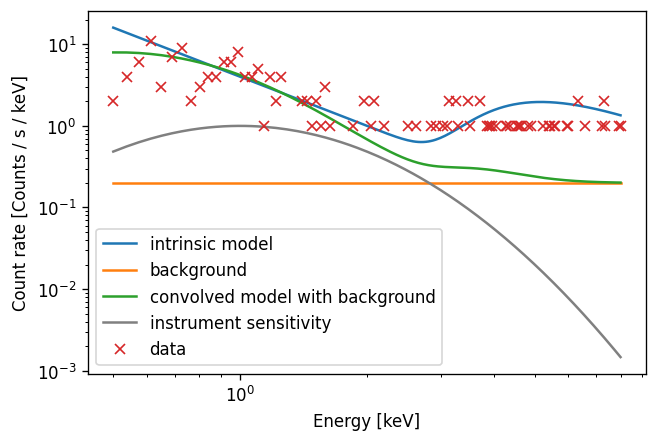

In [4]:
np.random.seed(1)

powerlaw_true = 2
nh_true = 100
fscat_true = 0.04
amplitude_true = 100
background_true = 0.2
paramnames = ['logamplitude', 'photonindex', 'lognh', 'logfscat', 'background']
ndim = len(paramnames)

E = np.linspace(0.5, 8, 200)
sensitivity = exp(-0.5 * (log10(E / 1.)/0.25)**2)
model = amplitude_true * E**-powerlaw_true * (fscat_true + exp(-nh_true * E**-3))
model_convolved = model * sensitivity + background_true

plt.plot(E, model, label='intrinsic model')
plt.plot(E, model * 0 + background_true, label='background')
plt.plot(E, model_convolved, label='convolved model with background')
plt.plot(E, sensitivity, color='gray', label='instrument sensitivity')
data = np.random.poisson(model_convolved)
plt.plot(E, data, 'x ', label='data')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('Count rate [Counts / s / keV]')
plt.legend(loc='best')

@mem.cache
def performfit(data, **kwargs):
    print('\nfitting %d counts' % data.sum())

    def loglike(params):
        logamplitude, photonindex, lognh, logfscat, background = params
        model = 10**logamplitude * E**-photonindex * (10**logfscat + exp(-10**lognh * E**-3))
        model_convolved = model * sensitivity + background_true
        logls = scipy.stats.poisson.logpmf(data, model_convolved)
        logls[~np.isfinite(logls)] = -1e300
        return logls.sum()

    def transform(x):
        z = x.copy()
        z[0] = x[0] * 10 - 5
        z[1] = scipy.stats.norm.ppf(x[1], loc=2.0, scale=0.2)
        z[2] = x[2] * 6 - 3
        z[3] = -1 - x[3] * 3
        z[4] = exp(scipy.stats.norm.ppf(x[4], loc=log(background_true), scale=0.1))
        return z

    from ultranest import ReactiveNestedSampler
    import logging
    logging.getLogger('ultranest').setLevel(logging.ERROR)
    sampler = ReactiveNestedSampler(paramnames, loglike, transform=transform)
    results = sampler.run(**kwargs)
    return results


In [5]:
results = performfit(data)


fitting 164 counts
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .85 [-181.9821..-181.9817]*| it/evals=5427/55195 eff=9.9042% N=400 400  
[ultranest] Likelihood function evaluations: 55205
[ultranest]   logZ = -190.9 +- 0.08259
[ultranest] Effective samples strategy satisfied (ESS = 2821.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.


Removed no burn in


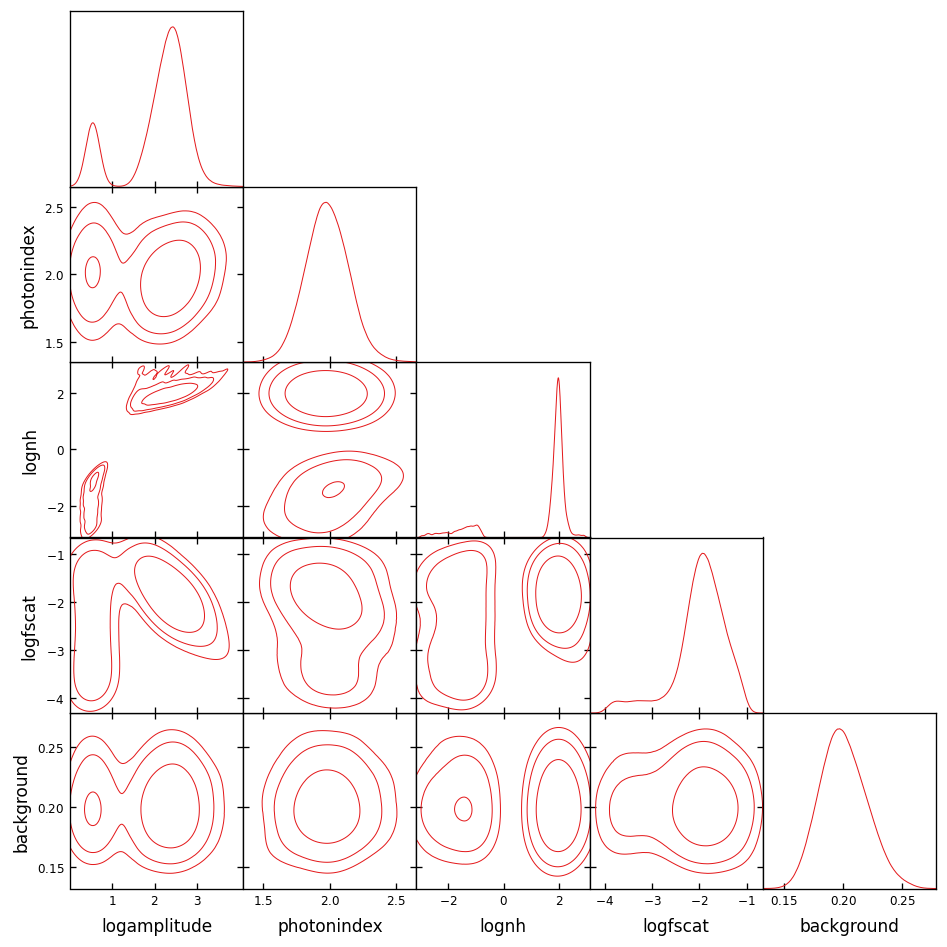

In [6]:
from getdist import MCSamples, plots
samples_g = MCSamples(samples=results['samples'], names=paramnames, settings=dict(smooth_scale_2D=3.0), 
                      label='NS', sampler='nested')

g = plots.get_subplot_plotter(width_inch=8)
g.settings.num_plot_contours = 3
g.triangle_plot([samples_g], filled=False, contour_colors=plt.cm.Set1.colors);


## two solutions in logNH:

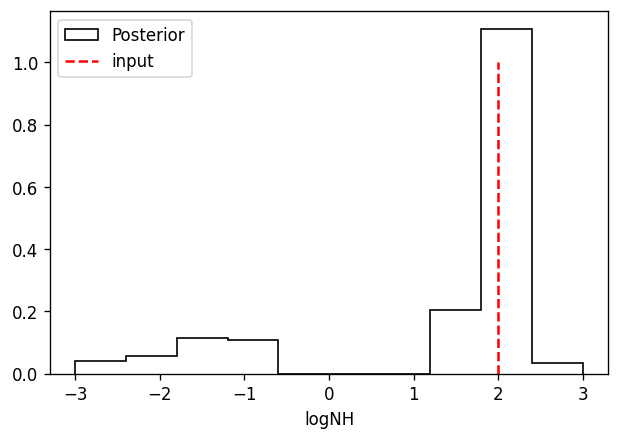

In [7]:
logNH = results['samples'][:,2]
plt.figure()
plt.hist(logNH, density=True, histtype='step', color='k', label='Posterior')
plt.vlines(2, 0, 1, color='r', ls='--', label='input')
plt.legend(loc='upper left')
plt.xlabel('logNH');

## Lets generate a sample:

In [16]:
np.random.seed(42)

sample = []

for i in range(15):
    powerlaw_true = 2
    nh_true = 100
    fscat_true = 0.04
    amplitude_true = 1/np.random.uniform(1./100, 1/4000)
    background_true = 0.2
    paramnames = ['logamplitude', 'photonindex', 'lognh', 'logfscat', 'background']
    ndim = len(paramnames)

    E = np.linspace(0.5, 8, 200)
    sensitivity = exp(-0.5 * (log10(E / 1.)/0.25)**2)
    model = amplitude_true * E**-powerlaw_true * (fscat_true + exp(-nh_true * E**-3))
    model_convolved = model * sensitivity + background_true
    data = np.random.poisson(model_convolved)
    sample.append(data)



## Fit them all

In [17]:
sample_results = [performfit(data, frac_remain=0.5, viz_callback=None) for data in sample]


fitting 252 counts
Z=-201.8(49.28%) | Like=-193.69..-191.56 [-193.6943..-193.6918]*| it/evals=3600/66700 eff=5.4299% N=400 00  
fitting 873 counts
Z=-257.8(49.97%) | Like=-250.33..-247.84 [-250.3326..-250.3317]*| it/evals=3258/80904 eff=4.0470% N=400 400 0 
fitting 245 counts
Z=-207.0(48.37%) | Like=-198.19..-196.05 [-198.1855..-198.1822]*| it/evals=3840/44707 eff=8.6668% N=400 400 
fitting 760 counts
Z=-261.0(47.87%) | Like=-250.13..-248.58 [-250.1329..-250.1318]*| it/evals=4560/66692 eff=6.8787% N=400 00  
fitting 193 counts
Z=-186.1(49.72%) | Like=-180.07..-177.43 [-180.0653..-180.0653]*| it/evals=2680/39090 eff=6.9269% N=400 400  
fitting 317 counts
Z=-211.6(49.00%) | Like=-203.82..-201.27 [-203.8202..-203.8178]*| it/evals=3600/110407 eff=3.2725% N=400 00 
fitting 425 counts
Z=-219.0(49.87%) | Like=-212.27..-209.52 [-212.2683..-212.2655]*| it/evals=2975/109418 eff=2.7289% N=400 00 
fitting 193 counts
Z=-177.8(49.49%) | Like=-171.60..-170.86 [-171.5963..-171.5948]*| it/evals=2600/3

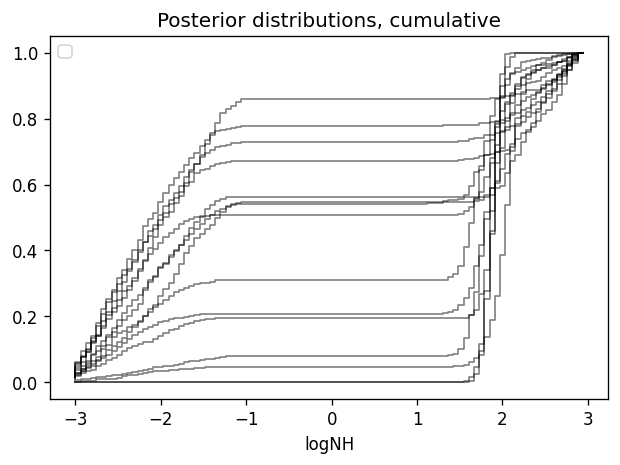

In [19]:
bins = np.linspace(-3, 3, 100)

sample_logNHs = np.array([result['samples'][:1000,2] for result in sample_results])

plt.figure()
plt.title("Posterior distributions, cumulative")
for i, logNH_result in enumerate(sorted(sample_logNHs, key=lambda samples: np.std(samples))):
    values, edges = np.histogram(logNH_result, bins=bins, density=True)
    plt.plot(edges[:-1], values.cumsum() / values.sum(), drawstyle='steps-pre', color='k', lw=1, alpha=0.5)

#plt.vlines(2, 0, 5, color='r', ls='--', label='input')
plt.legend(loc='upper left')
plt.xlabel('logNH');

# Methods to estimate intrinsic distribution

## Bad method 1: Stack histograms

Here, the histograms are added on top of each other. Equivalently, all the posterior samples are merged.

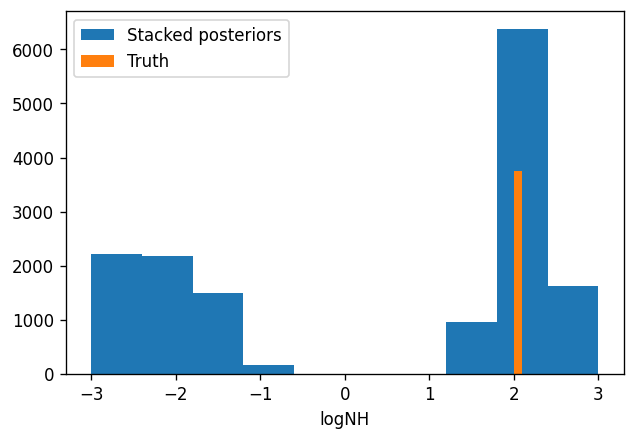

In [20]:
plt.figure()
allsamples = np.concatenate(sample_logNHs)
plt.hist(allsamples, label='Stacked posteriors')
plt.hist(np.ones(len(allsamples)//4) * log10(nh_true), label='Truth')

plt.legend(loc='upper left')
plt.xlabel('logNH');

* The stacked histograms **mixes measurement uncertainty with intrinsic distribution**
* This wrongly suggests that there are logNH<0 values in our sample

## Bad method 2: randomly sample a true point from each posterior

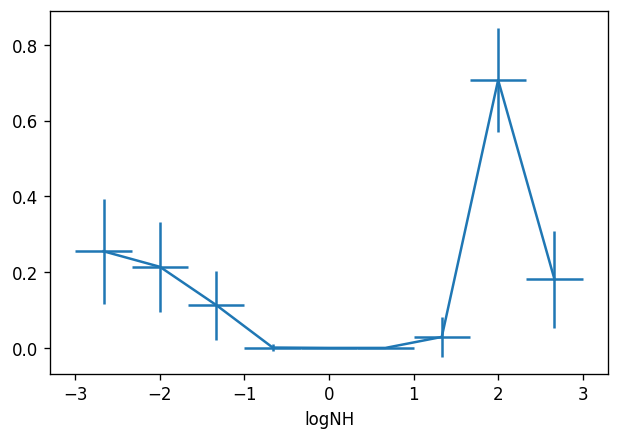

In [21]:
bins = np.linspace(-3, 3, 10)

plt.figure()
allhists = []
for i in range(100):
    values, edges = np.histogram([np.random.choice(logNH) for logNH in sample_logNHs], bins=bins, density=True)
    allhists.append(values)

plt.errorbar(
    x=(bins[1:] + bins[:-1]) / 2,
    xerr=(bins[1:] - bins[:-1]) / 2,
    y=np.mean(allhists, axis=0),
    yerr=np.std(allhists, axis=0),
)
plt.xlabel('logNH');

* The randomly sampled posteriors also **mixes measurement uncertainty with intrinsic distribution**
* This wrongly suggests that there are logNH<0 values in our sample
* It also underestimates the uncertainties, and suggests the uncertainties are uncorrelated

## Hierarchical Bayesian model

Lets define a simple population model, where we have some density at <0 and >0 (two bins).

We only have one parameter, defining the fraction above 0. You can later expand this to more fractions.


In [22]:
posteriors_above = (sample_logNHs > 0).mean(axis=1)
print('fraction of the posterior at logNH>0 for each dataset:\n', posteriors_above)

def loglike_population(fraction):
    prob = posteriors_above * fraction + (1 - fraction) * (1 - posteriors_above)
    return log(prob + 1e-100).sum()

def transform_population(u):
    return u # uniform from 0 to 1

paramnames_population = ['fraction']

from ultranest import ReactiveNestedSampler
import logging
logging.getLogger('ultranest').setLevel(logging.ERROR)
sampler = ReactiveNestedSampler(paramnames_population, loglike_population, transform=transform_population)
population_results = sampler.run()


fraction of the posterior at logNH>0 for each dataset:
 [0.792 0.437 0.953 1.    0.458 0.69  0.494 0.221 0.92  0.328 0.14  1.
 0.804 0.453 0.272]


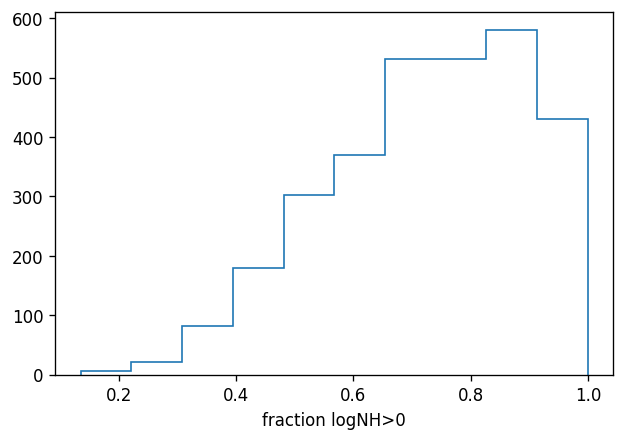

In [33]:
plt.figure()

plt.hist(population_results['samples'][:,0], histtype='step')
plt.xlabel('fraction logNH>0');

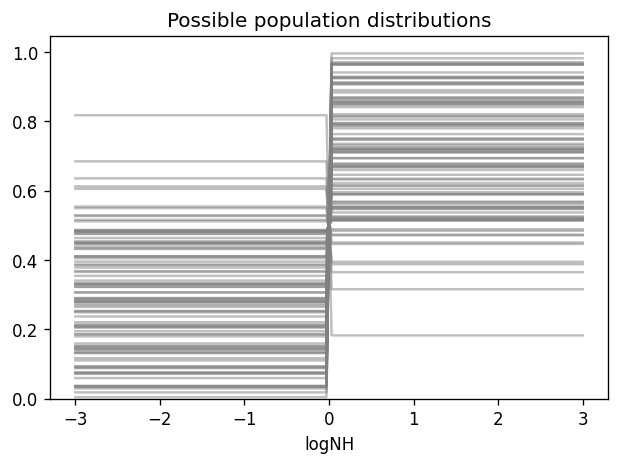

In [35]:
plt.figure()
bins = np.linspace(-3, 3, 100)

from ultranest.plot import PredictionBand

#band = PredictionBand(bins)
for fraction in population_results['samples'][:100,0]:
    #band.add(np.where(bins < 0, 1 - fraction, fraction))
    plt.plot(bins, np.where(bins < 0, 1 - fraction, fraction), color='gray', alpha=0.5)

plt.title('Possible population distributions')
#band.line(color='k')
#band.shade(q=0.45, color='k', alpha=0.1)
plt.ylim(0, None)
plt.xlabel('logNH');

## Takeaways

* The Hierarchical Bayesian model allows
  * high logNH>0 fractions
  * high logNH<0 fractions
  * and gives them similar probability (see posterior of fraction two plots up)
* Here, the measurement uncertainty is separated from the population distribution, because we average over each sample's posterior.
* This performs more reliably than stacking or sampling from posterior samples. However, a population distribution needs to be assumed.


I used this method in [Buchner+15](https://ui.adsabs.harvard.edu/abs/2015ApJ...802...89B/abstract)
